# TUTORIAL: Sentiment analysis on Tweets using Hugging Face

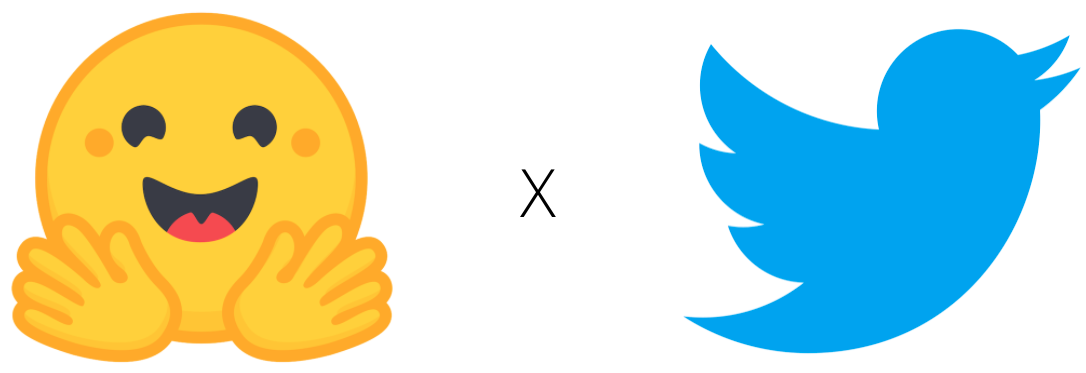

The aim of this tutorial is to use NLP to analyse sentiments on Tweets.

### USE CASE: OVHcloud French Tweets

A pre-trained [Hugging Face](https://huggingface.co/) model based on [camemBERT](https://huggingface.co/transformers/model_doc/camembert.html) was then chosen to allow an optimal analysis of the sentiments of these Tweets: [pt-tblard-tf-allocine](https://huggingface.co/philschmid/pt-tblard-tf-allocine).

## Introduction

**What is Hugging Face?**

Hugging Face is a NLP startup, known for creating open-source software such as Transformers and Datasets, which are used for building NLP systems. Hugging Face models can be used for classification, question answering, translation and many other NLP tasks.

## Code
- Install and import dependencies
- Load your dataset with Tweets
- Display the parameters you need
- Define the preprocess function
- Specify Tweets language
- Download the pretrained model
- Run an analysis of Tweets using the model
- Export the results
- Display the results

### Step 1 - Install and import dependencies

Before starting, **install the "*requirements.txt*" file**.

⚠️ Remember to restart the kernel after installations!

In [1]:
#import dependencies
import transformers
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt

In [2]:
# check GPU availability
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.0 _CudaDeviceProperties(name='Tesla V100S-PCIE-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)


### Step 2 - Load your dataset with Tweets

First, you can load your data into an object container, named `data` for example, stored in [Object Storage](https://docs.ovh.com/gb/en/ai-training/data-cli/).

The path to your data becomes: `/workspace/data`

In [3]:
dataframe = pd.read_csv("/workspace/data/tweet_2021-10-16.csv",sep = ',')

# display the first row
dataframe.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,entities/hashtags/3/indices/1,entities/hashtags/4/text,entities/hashtags/4/indices/0,entities/hashtags/4/indices/1,entities/hashtags/5/text,entities/hashtags/5/indices/0,entities/hashtags/5/indices/1,entities/hashtags/6/text,entities/hashtags/6/indices/0,entities/hashtags/6/indices/1
0,Sat Oct 16 00:28:11 +0000 2021,1449170272016379907,1449170272016379907,RT @cedric_o: Un grand jour pour la #FrenchTec...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sat Oct 16 00:50:33 +0000 2021,1449175900117942272,1449175900117942272,RT @ssddanbrown: The services we use to help m...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sat Oct 16 00:50:46 +0000 2021,1449175954727833600,1449175954727833600,RT @ssddanbrown: The services we use to help m...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sat Oct 16 01:37:03 +0000 2021,1449187600128827394,1449187600128827394,Datacenters:: [CA] Manager / api / order funne...,"<a href=""https://travaux.ovh.net"" rel=""nofollo...",True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sat Oct 16 01:41:13 +0000 2021,1449188651003432962,1449188651003432962,"My #OVH VPS is still performing badly, network...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 3 - Display the parameters you need

For the purposes of this tutorial, we are only interested in the `Tweets` and `Language `columns.

In [4]:
# choose the 2 columns
tweets = dataframe['text'].values
langs = dataframe['lang'].values

# the 5 first rows
print("tweets:",tweets[:5])
print("langs:",langs[:5])

tweets: ['RT @cedric_o: Un grand jour pour la #FrenchTech ! @OVHcloud_FR et ses 2500 salariés font leur entrée à la bourse de Paris🚀 Une histoire🇪🇺🇫🇷…'
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…'
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…'
 'Datacenters:: [CA] Manager / api / order funnel: Hello,\nWe detected that a small part of our traffic on public API… https://t.co/wVNxnE0UXU'
 'My #OVH VPS is still performing badly, network-wise. How about yours? #vps']
langs: ['fr' 'en' 'en' 'en' 'en']


### Step 4 - Define the preprocess function

In [5]:
def data_preprocess(words):  
    # split string into words
    words = words.split(' ')
    
    # remove URLS
    words = [word for word in words if not word.startswith('http')]
    words = ' '.join(words)
    
    # remove extra spaces
    words = re.sub(' +', ' ', words) 
    return words

In [6]:
tweets = [data_preprocess(tweet) for tweet in tweets]
tweets[:5]

['RT @cedric_o: Un grand jour pour la #FrenchTech ! @OVHcloud_FR et ses 2500 salariés font leur entrée à la bourse de Paris🚀 Une histoire🇪🇺🇫🇷…',
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…',
 'RT @ssddanbrown: The services we use to help manage the BookStack project, Featuring: \n\n@github \n@PlausibleHQ \n@TeamStyleCI \n@crowdin \n@cod…',
 'Datacenters:: [CA] Manager / api / order funnel: Hello,\nWe detected that a small part of our traffic on public API…',
 'My #OVH VPS is still performing badly, network-wise. How about yours? #vps']

### Step 5 - Specify Tweets language

In [7]:
# create list
french_tweets = []
i=0

# save only the french Tweets
for i in range(len(langs)):
    if langs[i] == 'fr' :
        french_tweets.append(tweets[i])
    i+=1
french_tweets_df = pd.DataFrame(french_tweets)

# display the five first Tweets
print("Tweets in french only:",french_tweets_df[:5])

Tweets in french only:                                                    0
0  RT @cedric_o: Un grand jour pour la #FrenchTec...
1  RT @GroupeSGM: Nous souhaitons féliciter @OVHc...
2  Cloud:: PCI - GRA7 - host1351101: \n• Incident...
3  Network and racks:: 42E18: Résumé : Nous avons...
4  Network and racks:: 42E18: Résumé : Nous avons...


### Step 6 - Download the pretrained models

In [ ]:
# model for sentiment analysis
sentiment = transformers.pipeline('sentiment-analysis', model="philschmid/pt-tblard-tf-allocine")

# model for entities classification
classifier = transformers.pipeline("zero-shot-classification", model="BaptisteDoyen/camembert-base-xnli")
entities = ["bourse", "IPO", "incident", "panne", " "] 

summarizer = transformers.pipeline("summarization")

### Step 7 - Run an analysis of Tweets using models

In [9]:
# test on the first Tweet of the day
print(french_tweets[0])
print(sentiment(french_tweets[0]))
print(classifier(french_tweets[0], entities))

RT @cedric_o: Un grand jour pour la #FrenchTech ! @OVHcloud_FR et ses 2500 salariés font leur entrée à la bourse de Paris🚀 Une histoire🇪🇺🇫🇷…
[{'label': 'POSITIVE', 'score': 0.8428646326065063}]
{'sequence': 'RT @cedric_o: Un grand jour pour la #FrenchTech ! @OVHcloud_FR et ses 2500 salariés font leur entrée à la bourse de Paris🚀 Une histoire🇪🇺🇫🇷…', 'labels': ['bourse', ' ', 'IPO', 'incident', 'panne'], 'scores': [0.4022144079208374, 0.3127315640449524, 0.1268693208694458, 0.1027987003326416, 0.0553860068321228]}


In [10]:
# transform into a dataframe
french_tweet_entity_df = pd.DataFrame(classifier(french_tweets, entities))

labels = french_tweet_entity_df["labels"]
scores = french_tweet_entity_df["scores"]

The classifier returns all entities and their probabilities. 

We want to save only the **dominant entity** and its **probability**.

In [11]:
# select only the principal entity 
label = []
score = []

i = 0

# for each Tweet, choose the first entity of the list and the first corresponding score
for i in range(len(labels)):
    label.append(labels[i][0])
    score.append(scores[i][0])
    i+=1

 It is possible to define each column of the result table:
 - Tweets (*text*)
 - Entities (*entity*)
 - Entities score (*score_entity*)
 - Sentiments (*label*)
 - Sentiments score (*score*)

In [12]:
# define columns of the results file
french_tweets_text = pd.DataFrame(french_tweets, columns = ['text'])
french_tweets_entity = pd.DataFrame(label, columns = ['entity'])
french_tweets_score_entity = pd.DataFrame(score, columns = ['score_entity'])
french_tweet_sentiment_df = pd.DataFrame(sentiment(french_tweets))

In [13]:
# concatenate the list of tweets and the results of sentiment analysis
results_16_10_2021_french_tweets = pd.concat([french_tweets_text, french_tweets_entity, french_tweets_score_entity, french_tweet_sentiment_df], axis=1)
results_16_10_2021_french_tweets

,text,entity,score_entity,label,score
0,RT @cedric_o: Un grand jour pour la #FrenchTec...,bourse,0.402214,POSITIVE,0.842865
1,RT @GroupeSGM: Nous souhaitons féliciter @OVHc...,bourse,0.503235,POSITIVE,0.785435
2,Cloud:: PCI - GRA7 - host1351101: \n• Incident...,incident,0.710761,NEGATIVE,0.576088
3,Network and racks:: 42E18: Résumé : Nous avons...,panne,0.600552,NEGATIVE,0.706324
4,Network and racks:: 42E18: Résumé : Nous avons...,panne,0.600552,NEGATIVE,0.706324
...,...,...,...,...,...
126,Opération clé pour la bourse de Paris. Qu’est ...,bourse,0.487064,POSITIVE,0.797323
127,RT @Vincent_Le_Sann: Opération clé pour la bou...,bourse,0.506258,POSITIVE,0.818157
128,"@ovh_support_fr, help ! Perdu mon authenticato...",panne,0.341974,NEGATIVE,0.827018
129,Ça fait maintenant 15 jours que je n'ai plus a...,,0.321152,NEGATIVE,0.749507


### Step 8 - Export the results

In [14]:
# export results as a csv file
%cd /workspace/results
results_16_10_2021_french_tweets.to_csv("results_16_10_2021_french_tweets_camembert.csv")

/workspace/results


### Step 9 - Display the results

In [15]:
labels = results_16_10_2021_french_tweets['label'].values
entity = results_16_10_2021_french_tweets['entity'].values

Text(0.5, 1.0, 'OVHcloud french Tweets sentiment - CamemBERT - 16th October 2021 ')

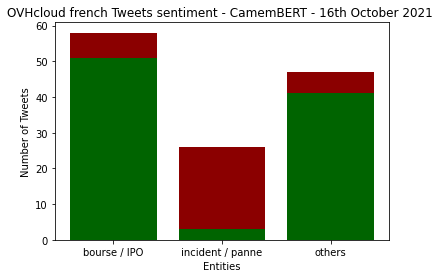

In [16]:
# define entities list
entities = ["bourse / IPO", "incident / panne", "others"] 

posi_bourse_IPO = []     # positive bourse/IPO
nega_bourse_IPO = []     # negative bourse/IPO
posi_inci_panne = []     # positive incident/panne
nega_inci_panne = []     # negative incident/panne
posi_others = []         # positive others
nega_others = []         # negative others

# split positive and negative labels
for i in range(len(labels)):
    if entity[i] == 'bourse' or entity[i] == 'IPO':
        if labels[i] == 'POSITIVE' :
            posi_bourse_IPO.append(labels[i])
        else:
            nega_bourse_IPO.append(labels[i])
    elif entity[i] == 'incident' or entity[i] == 'panne':
        if labels[i] == 'POSITIVE' :
            posi_inci_panne.append(labels[i])
        else:
            nega_inci_panne.append(labels[i])
    else:
        if labels[i] == 'POSITIVE' :
            posi_others.append(labels[i])
        else:
            nega_others.append(labels[i])
    i+=1

# define positive and negative list
positive = [posi_bourse_IPO.count('POSITIVE'), posi_inci_panne.count('POSITIVE'), posi_others.count('POSITIVE')]
negative = [nega_bourse_IPO.count('NEGATIVE'), nega_inci_panne.count('NEGATIVE'), nega_others.count('NEGATIVE')]

# display histogram
plt.bar(entities, positive, color = 'darkgreen')
plt.bar(entities, negative, bottom = positive, color = 'darkred')
plt.xlabel("Entities")
plt.ylabel("Number of Tweets")
plt.title("OVHcloud french Tweets sentiment - CamemBERT - 16th October 2021 ")

In [17]:
# number of positive and negative Tweets
french_tweet_sentiment_df['label'].value_counts()

POSITIVE    95
NEGATIVE    36
Name: label, dtype: int64